## Imbalance treatment within Cross validation for classification

Interesting Time feature Idea: Convert to user local time. For example, if you are trying to predict something that occurs around 8pm for all users, if you look at UTC time, it will be harder to predict from.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

In [2]:
import seaborn as sns
import numpy as np

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
##from imblearn.datasets import fetch_datasets
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")


/mnt/anaconda3/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/mnt/anaconda3/lib/python3.5/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [5]:
pd.set_option('display.max_columns', 500)

In [6]:
def missing_pct(df):
    h_list = []
    for i in df:
        h_list.append(i)
        h_list.append(sum(df[i].isna())/len(df[i]))
        
    return h_list

In [7]:
from sklearn.preprocessing import LabelEncoder

In [8]:
train = pd.read_csv('training_data.csv')
train.rename(columns = lambda x: x.lower(), inplace = True)

In [9]:
missing_pct(train)

['app_id',
 0.0,
 'business_id',
 0.04990334572490707,
 'lead_source_id',
 0.04990334572490707,
 'carrier_id',
 0.04990334572490707,
 'state_id',
 0.04990334572490707,
 'gender',
 0.04996282527881041,
 'application_type',
 0.04990334572490707,
 'plan_letter',
 0.04990334572490707,
 'age',
 0.0,
 'spouse_policy_attached',
 0.04990334572490707,
 'lead_created_date',
 0.04990334572490707,
 'withdrawn',
 0.04990334572490707]

In [10]:
# row count by total observations in columns (45 columns) 
train['nans'] = train.apply(lambda x: sum(x.isna()), axis=1)

In [11]:
# all Na 1680 rows out of 33k
train1 = train.dropna()

In [12]:
test = pd.read_csv('test_data.csv')
test.rename(columns = lambda x: x.lower(), inplace = True)

In [13]:
test['withdrawn'].value_counts()

0.0    12540
1.0     3192
Name: withdrawn, dtype: int64

In [14]:
# 830 NA 10 columns out of 16k
test['nans'] = test.apply(lambda x: sum(x.isna()), axis=1)

In [ ]:
test1[test1.business_id==0.0]

In [17]:
test1 = test.dropna()

In [18]:
train1['split'] = 1

In [19]:
test1['split'] = 0

In [20]:
test1[test1.business_id==0.0]

,app_id,business_id,lead_source_id,carrier_id,state_id,gender,application_type,plan_letter,age,spouse_policy_attached,lead_created_date,withdrawn,nans,split


In [21]:
train_test = pd.concat([train1, test1], sort=True)

In [22]:
train_test.business_id.value_counts()

1.0    46233
2.0     1443
Name: business_id, dtype: int64

In [23]:
from datetime import datetime #, '%d-%m-%Y'
train_test['lead_dt'] = pd.to_datetime(train_test.lead_created_date)
train_test['lead_dt_yr'] = train_test['lead_dt'].dt.year
train_test['lead_dt_mon'] = train_test['lead_dt'].dt.month
train_test['lead_dt_day'] = train_test['lead_dt'].dt.day
train_test['lead_dt_hr'] = train_test['lead_dt'].dt.hour
train_test['lead_dt_min'] = train_test['lead_dt'].dt.minute
train_test['weekday']= train_test['lead_dt'].dt.weekday

In [24]:
train_test1 =train_test[train_test['lead_dt_yr']>=2014.0]

In [25]:
train_test1 =train_test1.drop(['app_id', 'lead_created_date', 'lead_dt' ,'nans'], axis=1)

In [26]:
train_test1.dtypes

age                       float64
application_type           object
business_id               float64
carrier_id                float64
gender                     object
lead_source_id            float64
plan_letter                object
split                       int64
spouse_policy_attached    float64
state_id                  float64
withdrawn                 float64
lead_dt_yr                float64
lead_dt_mon               float64
lead_dt_day               float64
lead_dt_hr                float64
lead_dt_min               float64
weekday                   float64
dtype: object

In [380]:
train_test1.head()

,age,application_type,business_id,carrier_id,gender,lead_source_id,plan_letter,split,spouse_policy_attached,state_id,withdrawn,lead_dt_yr,lead_dt_mon,lead_dt_day,lead_dt_hr,lead_dt_min,weekday
0,65.038764,Type 1,1.0,11.0,Male,233.0,A,1,0.0,31.0,0.0,2018.0,4.0,24.0,9.0,55.0,1.0
1,66.489092,Type 1,1.0,12.0,M,86.0,A,1,0.0,30.0,0.0,2018.0,4.0,13.0,8.0,6.0,4.0
2,63.668061,Type 1,1.0,4.0,Male,180.0,A,1,0.0,47.0,0.0,2018.0,7.0,19.0,8.0,23.0,3.0
3,65.636237,Type 1,1.0,9.0,Male,226.0,C,1,0.0,41.0,0.0,2018.0,8.0,6.0,15.0,9.0,0.0
4,65.688688,Type 1,1.0,11.0,M,111.0,B,1,0.0,35.0,0.0,2018.0,3.0,20.0,14.0,50.0,1.0


In [28]:
train_test2 = train_test1.copy()
train_test2 = train_test2[train_test2['gender']!=1]
train_test2['gender'] = train_test2['gender'].apply(lambda x: x.lower())
train_test2['gender'] = [0 if k == 'm' or k == 'male' else 1 for k in train_test2.gender]
train_test2['business_id'] = [0 if k == 1.0 else 1 for k in train_test2.business_id] 
train_test2['application_type'] = [0 if k =='Type 1' else 1 for k in train_test2['application_type'] ]
train_test2['lead_source_id'] = train_test2['lead_source_id'].astype('str')
train_test2['lead_source_id'] = train_test2['lead_source_id'].apply(lambda x: x + '_lead_source')

In [29]:
train_test2['carrier_id'] = train_test2['carrier_id'].astype('str')
train_test2['carrier_id'] = train_test2['carrier_id'].apply(lambda x: x + '_carrier')

In [30]:
train_test2['state_id'] = train_test2['state_id'].astype('str')
train_test2['state_id'] = train_test2['state_id'].apply(lambda x: x + '_state')

In [31]:
train_test2.loc[(train_test2.withdrawn==1), 'application_type'].value_counts()

0    9842
1      23
Name: application_type, dtype: int64

In [32]:
train_test2['business_id'].value_counts()

0    46178
1     1442
Name: business_id, dtype: int64

In [33]:
train_test2['spouse_policy_attached'].value_counts()

0.0    41748
1.0     5872
Name: spouse_policy_attached, dtype: int64

In [34]:
train_test2.head()

,age,application_type,business_id,carrier_id,gender,lead_source_id,plan_letter,split,spouse_policy_attached,state_id,withdrawn,lead_dt_yr,lead_dt_mon,lead_dt_day,lead_dt_hr,lead_dt_min,weekday
0,65.038764,0,0,11.0_carrier,0,233.0_lead_source,A,1,0.0,31.0_state,0.0,2018.0,4.0,24.0,9.0,55.0,1.0
1,66.489092,0,0,12.0_carrier,0,86.0_lead_source,A,1,0.0,30.0_state,0.0,2018.0,4.0,13.0,8.0,6.0,4.0
2,63.668061,0,0,4.0_carrier,0,180.0_lead_source,A,1,0.0,47.0_state,0.0,2018.0,7.0,19.0,8.0,23.0,3.0
3,65.636237,0,0,9.0_carrier,0,226.0_lead_source,C,1,0.0,41.0_state,0.0,2018.0,8.0,6.0,15.0,9.0,0.0
4,65.688688,0,0,11.0_carrier,0,111.0_lead_source,B,1,0.0,35.0_state,0.0,2018.0,3.0,20.0,14.0,50.0,1.0


In [35]:
train_test2['age']=round(train_test2.age)

In [36]:
def calc_smooth_mean(df, by, on, m):
    # Compute the global mean
    mean = df[on].mean()

    # Compute the number of values and the mean of each group
    agg = df.groupby(by)[on].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']

    # Compute the "smoothed" means
    smooth = (counts * means + m * mean) / (counts + m)

    # Replace each value by the according smoothed mean
    return df[by].map(smooth)


In [37]:
train_test2['age1']=calc_smooth_mean(train_test2, by='age', on='withdrawn', m=300)

In [38]:
train_test2['carrier_id1']=calc_smooth_mean(train_test2, by='carrier_id', on='withdrawn', m=300)

In [39]:
train_test2['state_id1']=calc_smooth_mean(train_test2, by='state_id', on='withdrawn', m=250)

In [40]:
train_test2['lead_source_id1'] = calc_smooth_mean(train_test2, by='state_id', on='withdrawn', m=300)

In [41]:
train_test2.head()

,age,application_type,business_id,carrier_id,gender,lead_source_id,plan_letter,split,spouse_policy_attached,state_id,withdrawn,lead_dt_yr,lead_dt_mon,lead_dt_day,lead_dt_hr,lead_dt_min,weekday,age1,carrier_id1,state_id1,lead_source_id1
0,65.0,0,0,11.0_carrier,0,233.0_lead_source,A,1,0.0,31.0_state,0.0,2018.0,4.0,24.0,9.0,55.0,1.0,0.214122,0.144039,0.214365,0.214008
1,66.0,0,0,12.0_carrier,0,86.0_lead_source,A,1,0.0,30.0_state,0.0,2018.0,4.0,13.0,8.0,6.0,4.0,0.208894,0.254007,0.237010,0.234821
2,64.0,0,0,4.0_carrier,0,180.0_lead_source,A,1,0.0,47.0_state,0.0,2018.0,7.0,19.0,8.0,23.0,3.0,0.216173,0.218919,0.192230,0.193197
3,66.0,0,0,9.0_carrier,0,226.0_lead_source,C,1,0.0,41.0_state,0.0,2018.0,8.0,6.0,15.0,9.0,0.0,0.208894,0.209855,0.214760,0.214700
4,66.0,0,0,11.0_carrier,0,111.0_lead_source,B,1,0.0,35.0_state,0.0,2018.0,3.0,20.0,14.0,50.0,1.0,0.208894,0.144039,0.211176,0.210994


In [42]:
train_test3 = train_test2.drop(['carrier_id', 'lead_source_id', 'state_id'], axis=1)

In [43]:
le = LabelEncoder()

In [44]:
train_test3['plan_letter1'] = le.fit_transform(train_test3['plan_letter'])

In [47]:
train_test4 = pd.concat([train_test3.drop('plan_letter', axis=1), pd.get_dummies(train_test3['plan_letter'])], axis=1)

In [48]:
train_test4.drop('plan_letter1', axis=1, inplace=True)

In [49]:
time_di = {4: 0,5: 0, 6: 0, 7: 0, 8: 0, 9: 0,10: 0,
           11: 1, 12: 1,13: 1,14: 1, 
           15:2,16:2,17:2,18:2, 19:2, 20:2, 
           21: 3, 22: 3, 23: 3, 24: 3, 0: 3, 1: 3, 2: 3, 3: 3}

In [50]:
train_test4['lead_dt_hr1']=train_test4.lead_dt_hr.map(time_di)

In [51]:
## where Monday is 0 and Sunday is 6.
#test1['weekday']= test1['lead_dt'].dt.weekday

In [52]:
train_test4.drop(['lead_dt_day', 'lead_dt_hr'], axis=1,inplace=True)

In [53]:
train_test4['year1']=train_test4.lead_dt_yr + (train_test4.lead_dt_mon * .1)

In [54]:
train_test4['year2'] = calc_smooth_mean(train_test4, by='year1', on='withdrawn', m=300)

In [55]:
train_test4['lead_dt_mon'].value_counts()

8.0     6561
7.0     5689
6.0     5366
5.0     5286
9.0     5270
3.0     4823
4.0     4822
1.0     4363
2.0     4051
12.0     532
10.0     502
11.0     355
Name: lead_dt_mon, dtype: int64

In [56]:
di_mon = {1.0:0, 2.0:0, 3.0:0, 4.0:1, 5.0:1, 6.0:1, 7.0:2, 8.0:2, 9.0:2, 10.0:3, 11.0:3, 12.0:3}

In [57]:
train_test4['lead_dt_mon1'] = train_test4['lead_dt_mon'].map(di_mon)

In [59]:
train_test5 = train_test4.drop(['year1', 'lead_dt_min', 'lead_dt_mon', 'lead_dt_yr', 'age1'], axis=1)

In [60]:
train_test5.head()

,age,application_type,business_id,gender,split,spouse_policy_attached,withdrawn,weekday,carrier_id1,state_id1,lead_source_id1,A,B,C,lead_dt_hr1,year2,lead_dt_mon1
0,65.0,0,0,0,1,0.0,0.0,1.0,0.144039,0.214365,0.214008,1,0,0,0,0.211397,1
1,66.0,0,0,0,1,0.0,0.0,4.0,0.254007,0.237010,0.234821,1,0,0,0,0.211397,1
2,64.0,0,0,0,1,0.0,0.0,3.0,0.218919,0.192230,0.193197,1,0,0,0,0.201041,2
3,66.0,0,0,0,1,0.0,0.0,0.0,0.209855,0.214760,0.214700,0,0,1,2,0.216355,2
4,66.0,0,0,0,1,0.0,0.0,1.0,0.144039,0.211176,0.210994,0,1,0,1,0.197541,0


In [61]:
missing_pct(train_test5)

['age',
 0.0,
 'application_type',
 0.0,
 'business_id',
 0.0,
 'gender',
 0.0,
 'split',
 0.0,
 'spouse_policy_attached',
 0.0,
 'withdrawn',
 0.0,
 'weekday',
 0.0,
 'carrier_id1',
 0.0,
 'state_id1',
 0.0,
 'lead_source_id1',
 0.0,
 'A',
 0.0,
 'B',
 0.0,
 'C',
 0.0,
 'lead_dt_hr1',
 0.0,
 'year2',
 0.0,
 'lead_dt_mon1',
 0.0]

## Cyclical features for regression
df['hourfloat']=df.hour+df.minute/60.0
df['x']=np.sin(2.*np.pi*df.hourfloat/24.)
df['y']=np.cos(2.*np.pi*df.hourfloat/24.)

###### hour minute hourfloat x      y
###### 0     24     .40     .104528 .994522

df['hr_sin'] = np.sin(df.hr*(2.*np.pi/24))
df['hr_cos'] = np.cos(df.hr*(2.*np.pi/24))
df['mnth_sin'] = np.sin((df.mnth-1)*(2.*np.pi/12))
df['mnth_cos'] = np.cos((df.mnth-1)*(2.*np.pi/12))

## Train test split

In [62]:
train6 = train_test5.loc[train_test5.split==1]

In [63]:
train6.head()

,age,application_type,business_id,gender,split,spouse_policy_attached,withdrawn,weekday,carrier_id1,state_id1,lead_source_id1,A,B,C,lead_dt_hr1,year2,lead_dt_mon1
0,65.0,0,0,0,1,0.0,0.0,1.0,0.144039,0.214365,0.214008,1,0,0,0,0.211397,1
1,66.0,0,0,0,1,0.0,0.0,4.0,0.254007,0.237010,0.234821,1,0,0,0,0.211397,1
2,64.0,0,0,0,1,0.0,0.0,3.0,0.218919,0.192230,0.193197,1,0,0,0,0.201041,2
3,66.0,0,0,0,1,0.0,0.0,0.0,0.209855,0.214760,0.214700,0,0,1,2,0.216355,2
4,66.0,0,0,0,1,0.0,0.0,1.0,0.144039,0.211176,0.210994,0,1,0,1,0.197541,0


In [64]:
test6 = train_test5.loc[train_test5.split==0]

In [65]:
Xx = train6.drop(['withdrawn','split'], axis=1)

In [66]:
y = train6['withdrawn']

In [ ]:
X1 = X.drop(['business_id', 'application_type','29.0_state', '3.0_state', '33.0_state',
       '36.0_state', '40.0_state', '41.0_state', '43.0_state', '9.0_state',
       'state_other'], axis=1)

In [ ]:
X.columns

In [ ]:
X2 = X1.iloc[:,X1.columns!= 'withdrawn']

In [ ]:
y = train5['withdrawn']

In [ ]:
X = train5.iloc[:,train5.columns!= 'withdrawn']

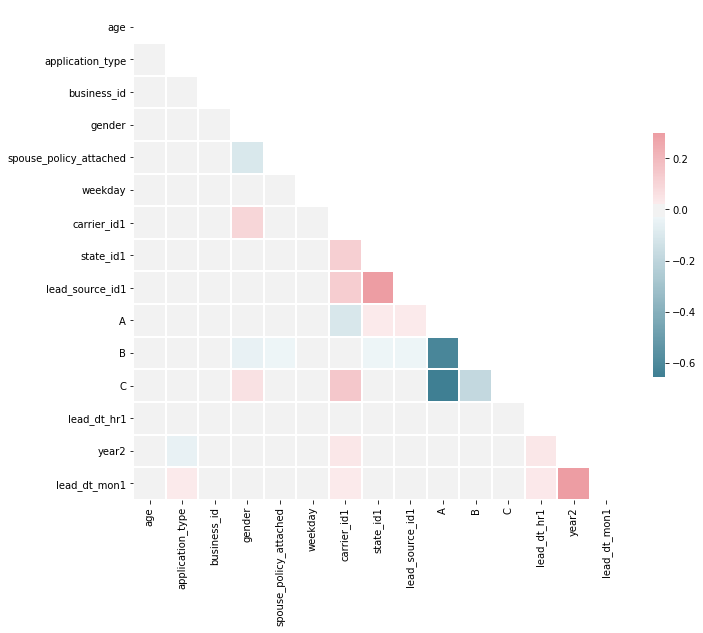

In [285]:
# Compute the correlation matrix
corr = X_train.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=1, cbar_kws={"shrink": .5})

In [132]:
X_train, X_test, y_train, y_test = train_test_split(Xx, y, test_size = .2, random_state = 42)

In [68]:
y_train.head()

5217     0.0
32029    0.0
26947    0.0
21325    1.0
9196     0.0
Name: withdrawn, dtype: float64

## Isolation Forest  
https://www.kaggle.com/rgaddati/unsupervised-fraud-detection-isolation-forest

In [295]:
from sklearn.ensemble import IsolationForest

In [359]:
inliers = train6[train6.withdrawn==0]
inliers = inliers.drop(['withdrawn'], axis=1)
outliers = train6[train6.withdrawn==1]
outliers = outliers.drop(['withdrawn'], axis=1)
inliers_train, inliers_test = train_test_split(inliers, test_size=0.20, random_state=42)

In [358]:
inliers.head()

,age,application_type,business_id,gender,split,spouse_policy_attached,weekday,carrier_id1,state_id1,lead_source_id1,A,B,C,lead_dt_hr1,year2,lead_dt_mon1
0,65.0,0,0,0,1,0.0,1.0,0.144039,0.214365,0.214008,1,0,0,0,0.211397,1
1,66.0,0,0,0,1,0.0,4.0,0.254007,0.237010,0.234821,1,0,0,0,0.211397,1
2,64.0,0,0,0,1,0.0,3.0,0.218919,0.192230,0.193197,1,0,0,0,0.201041,2
3,66.0,0,0,0,1,0.0,0.0,0.209855,0.214760,0.214700,0,0,1,2,0.216355,2
4,66.0,0,0,0,1,0.0,1.0,0.144039,0.211176,0.210994,0,1,0,1,0.197541,0


In [360]:
model = IsolationForest()
model.fit(train6.drop(['withdrawn'], axis=1))
inlier_pred_test = model.predict(inliers_test)
outlier_pred = model.predict(outliers)

In [361]:
print("Accuracy in Detecting Legit Cases:", list(inlier_pred_test).count(1)/inlier_pred_test.shape[0])
print("Accuracy in Detecting withdrawn Cases:", list(outlier_pred).count(-1)/outlier_pred.shape[0])

Accuracy in Detecting Legit Cases: 0.8937982960174361
Accuracy in Detecting withdrawn Cases: 0.09108614232209737


In [362]:
from sklearn.neighbors import LocalOutlierFactor

model = LocalOutlierFactor(novelty=True)
model.fit(inliers_train)
inlier_pred_test = model.predict(inliers_test)
outlier_pred = model.predict(outliers)

In [363]:
print("Accuracy in Detecting Legit Cases:", list(inlier_pred_test).count(1)/inlier_pred_test.shape[0])
print("Accuracy in Detecting Fraud Cases:", list(outlier_pred).count(-1)/outlier_pred.shape[0])

Accuracy in Detecting Legit Cases: 0.9029126213592233
Accuracy in Detecting Fraud Cases: 0.09258426966292135


## Another implementation attempt
https://www.kaggle.com/pavansanagapati/anomaly-detection-credit-card-fraud-analysis

In [364]:
Fraud = train6[train6['withdrawn']==1]

Valid = train6[train6['withdrawn']==0]

outlier_fraction = len(Fraud)/float(len(Valid))

In [365]:
print(outlier_fraction)

print("Fraud Cases : {}".format(len(Fraud)))

print("Valid Cases : {}".format(len(Valid)))

0.2645240548466355
Fraud Cases : 6675
Valid Cases : 25234


In [368]:
train6.head()

,age,application_type,business_id,gender,split,spouse_policy_attached,withdrawn,weekday,carrier_id1,state_id1,lead_source_id1,A,B,C,lead_dt_hr1,year2,lead_dt_mon1
0,65.0,0,0,0,1,0.0,0.0,1.0,0.144039,0.214365,0.214008,1,0,0,0,0.211397,1
1,66.0,0,0,0,1,0.0,0.0,4.0,0.254007,0.237010,0.234821,1,0,0,0,0.211397,1
2,64.0,0,0,0,1,0.0,0.0,3.0,0.218919,0.192230,0.193197,1,0,0,0,0.201041,2
3,66.0,0,0,0,1,0.0,0.0,0.0,0.209855,0.214760,0.214700,0,0,1,2,0.216355,2
4,66.0,0,0,0,1,0.0,0.0,1.0,0.144039,0.211176,0.210994,0,1,0,1,0.197541,0


In [369]:
columns = train6.columns.tolist()

In [370]:
columns

['age',
 'application_type',
 'business_id',
 'gender',
 'split',
 'spouse_policy_attached',
 'withdrawn',
 'weekday',
 'carrier_id1',
 'state_id1',
 'lead_source_id1',
 'A',
 'B',
 'C',
 'lead_dt_hr1',
 'year2',
 'lead_dt_mon1']

In [371]:
columns = [c for c in columns if c not in ["withdrawn"]]

In [372]:
columns

['age',
 'application_type',
 'business_id',
 'gender',
 'split',
 'spouse_policy_attached',
 'weekday',
 'carrier_id1',
 'state_id1',
 'lead_source_id1',
 'A',
 'B',
 'C',
 'lead_dt_hr1',
 'year2',
 'lead_dt_mon1']

In [373]:
columns = train6.columns.tolist()
# Filter the columns to remove data we do not want 
columns = [c for c in columns if c not in ["withdrawn"]]
# Store the variable we are predicting 
target = "withdrawn"
# Define a random state 
state = np.random.RandomState(42)
X = train6[columns]
Y = train6[target]
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))
# Print the shapes of X & Y
print(X.shape)
print(Y.shape)

(31909, 16)
(31909,)


In [376]:
from sklearn.svm import OneClassSVM

In [377]:
classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(X), 
                                       contamination=outlier_fraction,random_state=state, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination=outlier_fraction),
    "Support Vector Machine":OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05, 
                                         max_iter=-1, random_state=state)}

In [378]:
n_outliers = len(Fraud)
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_prediction = clf.negative_outlier_factor_
    elif clf_name == "Support Vector Machine":
        clf.fit(X)
        y_pred = clf.predict(X)
    else:    
        clf.fit(X)
        scores_prediction = clf.decision_function(X)
        y_pred = clf.predict(X)
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != Y).sum()
    # Run Classification Metrics
    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(Y,y_pred))
    print("Classification Report :")
    print(classification_report(Y,y_pred))

Isolation Forest: 11828
Accuracy Score :
0.629320881256072
Classification Report :
              precision    recall  f1-score   support

         0.0       0.79      0.73      0.76     25234
         1.0       0.19      0.25      0.22      6675

    accuracy                           0.63     31909
   macro avg       0.49      0.49      0.49     31909
weighted avg       0.66      0.63      0.64     31909

Local Outlier Factor: 12036
Accuracy Score :
0.6228023441662227
Classification Report :
              precision    recall  f1-score   support

         0.0       0.78      0.73      0.75     25234
         1.0       0.18      0.23      0.20      6675

    accuracy                           0.62     31909
   macro avg       0.48      0.48      0.48     31909
weighted avg       0.66      0.62      0.64     31909

Support Vector Machine: 7666
Accuracy Score :
0.7597543012943057
Classification Report :
              precision    recall  f1-score   support

         0.0       0.79      0.

In [355]:
svc

SVC(C=0.7, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [296]:
class ExNode:
    def __init__(self,size):
        self.size=size
        
class InNode:
    def __init__(self,left,right,splitAtt,splitVal):
        self.left=left
        self.right=right
        self.splitAtt=splitAtt
        self.splitVal=splitVal

def iForest(X,noOfTrees,sampleSize):
    forest=[]
    hlim=math.ceil(math.log(sampleSize,2))
    for i in range(noOfTrees):
        X_train=X.sample(sampleSize)
        forest.append(iTree(X_train,0,hlim))
    return forest

def iTree(X,currHeight,hlim):
    if currHeight>=hlim or len(X)<=1:
        return ExNode(len(X))
    else:
        Q=X.columns
        q=random.choice(Q)
        p=random.choice(X[q].unique())
        X_l=X[X[q]<p]
        X_r=X[X[q]>=p]
        return InNode(iTree(X_l,currHeight+1,hlim),iTree(X_r,currHeight+1,hlim),q,p)

def pathLength(x,Tree,currHeight):
    if isinstance(Tree,ExNode):
        return currHeight
    a=Tree.splitAtt
    if x[a]<Tree.splitVal:
        return pathLength(x,Tree.left,currHeight+1)
    else:
        return pathLength(x,Tree.right,currHeight+1)

In [298]:
train_test5.shape

(47620, 17)

In [300]:
import math
import random

In [ ]:
Xx.sample(10000)

In [337]:
sampleSize=100
ifor=iForest(Xx.sample(1000),10,sampleSize)

In [325]:
random.choice(Xx[y==1].index)

17262

In [326]:
random.choice(Xx[y==0].index)

12633

In [ ]:
pathLength(Xx.iloc[ind],tree,0)

In [ ]:
for sim in range(1000):
    ind=random.choice(Xx[y==1].index)
    print (ind)

In [ ]:
posLenLst=[]
for tree in ifor:
        posLenLst.append(pathLength(Xx.iloc[ind],tree,0))

In [ ]:
pathLength(Xx.iloc[27834],tree,0)

In [ ]:
Xx.iloc[27834]

In [ ]:
posLenLst=[]
negLenLst=[]

for sim in range(10):
    ind=random.choice(Xx[y==1].index)
    for tree in ifor:
        posLenLst.append(pathLength(Xx.iloc[ind],tree,0))
        
    ind=random.choice(Xx[y==0].index)
    for tree in ifor:
        negLenLst.append(pathLength(Xx.iloc[ind],tree,0))

In [ ]:
bins = np.linspace(0,math.ceil(math.log(sampleSize,2)), math.ceil(math.log(sampleSize,2)))

pyplot.figure(figsize=(12,8))
pyplot.hist(posLenLst, bins, alpha=0.5, label='Anomaly')
pyplot.hist(negLenLst, bins, alpha=0.5, label='Normal')
pyplot.xlabel('Path Length')
pyplot.ylabel('Frequency')
pyplot.legend(loc='upper left')

### Try simple classifiers first

In [133]:
# Let's implement simple classifiers

classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    #"DecisionTreeClassifier": DecisionTreeClassifier()
}

In [74]:
from sklearn.preprocessing import MinMaxScaler

In [112]:
scaler = MinMaxScaler()
Xx[['age', 'weekday', 'lead_dt_hr1', 'lead_dt_mon1']] = scaler.fit_transform(Xx[['age', 'weekday', 'lead_dt_hr1', 'lead_dt_mon1']])

In [142]:
Xx.shape

(31909, 15)

In [134]:
Xx.head()

,age,application_type,business_id,gender,spouse_policy_attached,weekday,carrier_id1,state_id1,lead_source_id1,A,B,C,lead_dt_hr1,year2,lead_dt_mon1
0,0.3750,0,0,0,0.0,0.166667,0.144039,0.214365,0.214008,1,0,0,0.000000,0.211397,0.333333
1,0.4375,0,0,0,0.0,0.666667,0.254007,0.237010,0.234821,1,0,0,0.000000,0.211397,0.333333
2,0.3125,0,0,0,0.0,0.500000,0.218919,0.192230,0.193197,1,0,0,0.000000,0.201041,0.666667
3,0.4375,0,0,0,0.0,0.000000,0.209855,0.214760,0.214700,0,0,1,0.666667,0.216355,0.666667
4,0.4375,0,0,0,0.0,0.166667,0.144039,0.211176,0.210994,0,1,0,0.333333,0.197541,0.000000


In [89]:
from sklearn.model_selection import cross_val_score

for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 79.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 75.0 % accuracy score


In [75]:
X_train1 = MinMaxScaler(X_train)

In [73]:
LogisticRegression()

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [135]:
# Use GridSearchCV to find the best parameters.
from sklearn.model_selection import GridSearchCV

#For small values of C, we increase the regularization strength 
#which will create simple models which underfit the data. 
#For big values of C, we low the power of regularization 
#which imples the model is allowed to increase it's complexity,
#and therefore, overfit the data.

# Logistic Regression 
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}



grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train_res, y_train_res)
# We automatically get the logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_

knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train_res, y_train_res)
# KNears best estimator
knears_neighbors = grid_knears.best_estimator_



# DecisionTree Classifier
#tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
#              "min_samples_leaf": list(range(5,7,1))}
#grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
#grid_tree.fit(X_train, y_train)

# tree best estimator
#tree_clf = grid_tree.best_estimator_

In [289]:
# Support Vector Classifier
# Radial-basis function (gaussians) ; Polynominal ; Sigmoid, Linear
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(train_x_res, train_y_res)

# SVC best estimator
svc = grid_svc.best_estimator_

In [354]:
svc

SVC(C=0.7, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [293]:
svc_pred = svc.predict(X_test)

In [294]:
roc_auc_score(y_test,  svc_pred )

0.5716107563167507

In [290]:
svc_score = cross_val_score(svc, X_test, y_test, cv=5)
print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

Support Vector Classifier Cross Validation Score 79.6%


In [136]:
# Overfitting Case

log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')


knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')

# svc_score = cross_val_score(svc, X_train, y_train, cv=5)
# print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

#tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
#print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  78.95%
Knears Neighbors Cross Validation Score 77.12%


In [98]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

print('No withdrawns', round(train6['withdrawn'].value_counts()[0]/len(train6) * 100,2), '% of the dataset')
print('withdrawn', round(train6['withdrawn'].value_counts()[1]/len(train6) * 100,2), '% of the dataset')

X=train6.drop('withdrawn', axis=1)
y = train6['withdrawn']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# We already have X_train and y_train for undersample data thats why I am using original to distinguish and to not overwrite these variables.
# original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the Distribution of the labels


# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

No withdrawns 79.08 % of the dataset
withdrawn 20.92 % of the dataset
Train: [ 6327  6328  6330 ... 31906 31907 31908] Test: [   0    1    2 ... 6392 6393 6394]
Train: [    0     1     2 ... 31906 31907 31908] Test: [ 6327  6328  6330 ... 12785 12787 12789]
Train: [    0     1     2 ... 31906 31907 31908] Test: [12701 12705 12715 ... 19163 19164 19165]
Train: [    0     1     2 ... 31906 31907 31908] Test: [19078 19082 19083 ... 25554 25555 25556]
Train: [    0     1     2 ... 25554 25555 25556] Test: [25443 25452 25453 ... 31906 31907 31908]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.79081793 0.20918207]
[0.79078514 0.20921486]


In [ ]:
# Since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes.

# Lets shuffle the data before creating the subsamples

df = df.sample(frac=1)

# amount of fraud classes 492 rows.
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

In [231]:
# We will undersample during cross validating
undersample_X = train6.drop('withdrawn', axis=1)
undersample_y = train6['withdrawn']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(undersample_X, undersample_y):
    print("Train:", train_index, "Test:", test_index)
    undersample_Xtrain, undersample_Xtest = undersample_X.iloc[train_index], undersample_X.iloc[test_index]
    undersample_ytrain, undersample_ytest = undersample_y.iloc[train_index], undersample_y.iloc[test_index]
    
undersample_Xtrain = undersample_Xtrain.values
undersample_Xtest = undersample_Xtest.values
undersample_ytrain = undersample_ytrain.values
undersample_ytest = undersample_ytest.values 

undersample_accuracy = []
undersample_precision = []
undersample_recall = []
undersample_f1 = []
undersample_auc = []

# Implementing NearMiss Technique 
# Distribution of NearMiss (Just to see how it distributes the labels we won't use these variables)
#X_nearmiss, y_nearmiss = NearMiss().fit_sample(undersample_X.values, undersample_y.values)
#print('NearMiss Label Distribution: {}'.format(Counter(y_nearmiss)))
# Cross Validating the right way
rand_log_reg = RandomizedSearchCV(RandomForestClassifier(n_estimators=100), random_grid, n_iter=4)
for train, test in sss.split(undersample_Xtrain, undersample_ytrain):
    undersample_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), rand_log_reg) # SMOTE happens during Cross Validation not before..
    undersample_model = undersample_pipeline.fit(undersample_Xtrain[train], undersample_ytrain[train])
    undersample_prediction = undersample_model.predict(undersample_Xtrain[test])
    
    undersample_accuracy.append(undersample_pipeline.score(undersample_Xtrain[test], undersample_ytrain[test]))
    undersample_precision.append(precision_score(undersample_ytrain[test], undersample_prediction))
    undersample_recall.append(recall_score(undersample_ytrain[test], undersample_prediction))
    undersample_f1.append(f1_score(undersample_ytrain[test], undersample_prediction))
    undersample_auc.append(roc_auc_score(undersample_ytrain[test], undersample_prediction))

print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(undersample_accuracy)))
print("precision: {}".format(np.mean(undersample_precision)))
print("recall: {}".format(np.mean(undersample_recall)))
print("f1: {}".format(np.mean(undersample_f1)))
print ("AUC: {}".format(np.mean(undersample_auc)))
print('---' * 45)

Train: [ 6327  6328  6330 ... 31906 31907 31908] Test: [   0    1    2 ... 6392 6393 6394]
Train: [    0     1     2 ... 31906 31907 31908] Test: [ 6327  6328  6330 ... 12785 12787 12789]
Train: [    0     1     2 ... 31906 31907 31908] Test: [12701 12705 12715 ... 19163 19164 19165]
Train: [    0     1     2 ... 31906 31907 31908] Test: [19078 19082 19083 ... 25554 25555 25556]
Train: [    0     1     2 ... 25554 25555 25556] Test: [25443 25452 25453 ... 31906 31907 31908]
---------------------------------------------------------------------------------------------------------------------------------------

accuracy: nan
precision: nan
recall: nan
f1: nan
AUC: nan
---------------------------------------------------------------------------------------------------------------------------------------


In [145]:
# Let's Plot LogisticRegression Learning Curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator1, estimator2, 
                        #estimator3, estimator4, 
                        X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    f, (ax1, ax2) = plt.subplots(2, figsize=(20,14), sharey=True)
    if ylim is not None:
        plt.ylim(*ylim)
    # First Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator1, X_train, y_train, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax1.set_title("Logistic Regression Learning Curve", fontsize=14)
    ax1.set_xlabel('Training size (m)')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")
    
    # Second Estimator 
    train_sizes, train_scores, test_scores = learning_curve(
        estimator2, X_train, y_train, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax2.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax2.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax2.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax2.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax2.set_title("Knears Neighbors Learning Curve", fontsize=14)
    ax2.set_xlabel('Training size (m)')
    ax2.set_ylabel('Score')
    ax2.grid(True)
    ax2.legend(loc="best")
    return plt
#     # Third Estimator
#     train_sizes, train_scores, test_scores = learning_curve(
#         estimator3, Xx, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
#     train_scores_mean = np.mean(train_scores, axis=1)
#     train_scores_std = np.std(train_scores, axis=1)
#     test_scores_mean = np.mean(test_scores, axis=1)
#     test_scores_std = np.std(test_scores, axis=1)
#     ax3.fill_between(train_sizes, train_scores_mean - train_scores_std,
#                      train_scores_mean + train_scores_std, alpha=0.1,
#                      color="#ff9124")
#     ax3.fill_between(train_sizes, test_scores_mean - test_scores_std,
#                      test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
#     ax3.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
#              label="Training score")
#     ax3.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
#              label="Cross-validation score")
#     ax3.set_title("Support Vector Classifier \n Learning Curve", fontsize=14)
#     ax3.set_xlabel('Training size (m)')
#     ax3.set_ylabel('Score')
#     ax3.grid(True)
#     ax3.legend(loc="best")
    
    # Fourth Estimator
#     train_sizes, train_scores, test_scores = learning_curve(
#         estimator4, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
#     train_scores_mean = np.mean(train_scores, axis=1)
#     train_scores_std = np.std(train_scores, axis=1)
#     test_scores_mean = np.mean(test_scores, axis=1)
#     test_scores_std = np.std(test_scores, axis=1)
#     ax4.fill_between(train_sizes, train_scores_mean - train_scores_std,
#                      train_scores_mean + train_scores_std, alpha=0.1,
#                      color="#ff9124")
#     ax4.fill_between(train_sizes, test_scores_mean - test_scores_std,
#                      test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
#     ax4.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
#              label="Training score")
#     ax4.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
#              label="Cross-validation score")
#     ax4.set_title("Decision Tree Classifier \n Learning Curve", fontsize=14)
#     ax4.set_xlabel('Training size (m)')
#     ax4.set_ylabel('Score')
#     ax4.grid(True)
#     ax4.legend(loc="best")
      #return plt

### Learning Curves:
#### The wider the gap between the training score and the cross validation score, the more likely your model is overfitting (high variance).
##### If the score is low in both training and cross-validation sets this is an indication that our model is underfitting (high bias)
##### Logistic Regression Classifier shows the best score in both training and cross-validating sets.

In [162]:
def plot_learning_curve(estimator1, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    f, ax1 = plt.subplots(1, figsize=(20,14), sharey=True)
    if ylim is not None: plt.ylim(*ylim)
    train_sizes, train_scores, test_scores = learning_curve(estimator1, X, y, cv=cv, n_jobs=4, train_sizes=np.linspace(.1, 1.0, 5))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax1.set_title("Logistic Regression Learning Curve", fontsize=14)
    ax1.set_xlabel('Training size (m)')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")

In [150]:
train_sizes

array([ 2042,  6636, 11231, 15826, 20421])

In [173]:
train_sizes, train_scores, test_scores = learning_curve(log_reg, X, y, cv=cv, n_jobs=4, train_sizes=np.linspace(.1, 1.0, 5))
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

In [176]:
train_sizes

array([ 2552,  8296, 14039, 19783, 25527])

In [174]:
train_scores_mean

array([0.78330721, 0.78995902, 0.78979984, 0.79057777, 0.78998707])

In [175]:
test_scores_mean

array([0.79410843, 0.79410843, 0.79410843, 0.79410843, 0.79410843])

In [ ]:
train_sizes, train_scores, test_scores = learning_curve(svc, X, y, cv=cv, n_jobs=4, train_sizes=np.linspace(.1, 1.0, 5))
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

In [178]:
train_sizes

array([ 2552,  8296, 14039, 19783, 25527])

In [179]:
train_sizes

array([ 2552,  8296, 14039, 19783, 25527])

In [180]:
train_scores_mean

array([0.80995298, 0.80713597, 0.80864022, 0.80976091, 0.81018138])

In [181]:
test_scores_mean

array([0.7693513 , 0.77240677, 0.77569727, 0.77648073, 0.77577562])

In [ ]:
cv = ShuffleSplit(n_splits=2, test_size=0.2, random_state=42)
a = plot_learning_curve(log_reg, X_train, y_train, (0.87, 1.01), cv=cv, n_jobs=4)

In [193]:
X_train.head()

,age,application_type,business_id,gender,spouse_policy_attached,weekday,carrier_id1,state_id1,lead_source_id1,A,B,C,lead_dt_hr1,year2,lead_dt_mon1
5217,0.5625,0,0,1,0.0,0.166667,0.254007,0.227071,0.226662,1,0,0,0.333333,0.193318,0.000000
32029,0.4375,0,0,1,0.0,0.333333,0.228952,0.196575,0.196834,1,0,0,0.333333,0.201041,0.666667
26947,0.6250,0,0,1,0.0,0.166667,0.228952,0.187751,0.188111,0,0,1,1.000000,0.201041,0.666667
21325,0.6250,0,0,1,0.0,0.500000,0.228952,0.197907,0.198112,1,0,0,0.666667,0.211397,0.333333
9196,0.4375,0,0,1,0.0,0.000000,0.179908,0.187751,0.188111,1,0,0,0.333333,0.201041,0.666667


In [ ]:
RandomForestClassifier(n_estimators=)

In [208]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 100)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 110, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [284]:
X_train.head()

,age,application_type,business_id,gender,spouse_policy_attached,weekday,carrier_id1,state_id1,lead_source_id1,A,B,C,lead_dt_hr1,year2,lead_dt_mon1
5217,0.5625,0,0,1,0.0,0.166667,0.254007,0.227071,0.226662,1,0,0,0.333333,0.193318,0.000000
32029,0.4375,0,0,1,0.0,0.333333,0.228952,0.196575,0.196834,1,0,0,0.333333,0.201041,0.666667
26947,0.6250,0,0,1,0.0,0.166667,0.228952,0.187751,0.188111,0,0,1,1.000000,0.201041,0.666667
21325,0.6250,0,0,1,0.0,0.500000,0.228952,0.197907,0.198112,1,0,0,0.666667,0.211397,0.333333
9196,0.4375,0,0,1,0.0,0.000000,0.179908,0.187751,0.188111,1,0,0,0.333333,0.201041,0.666667


In [226]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV

original_Xtrain = X_train.values
original_Xtest = X_test.values
original_ytrain = y_train.values
original_ytest = y_test.values

print('Length of X (train): {} | Length of y (train): {}'.format(len(original_Xtrain), len(original_ytrain)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(X_test), len(y_test)))

# List to append the score and then find the average
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

# Classifier with optimal parameters
# log_reg_sm = grid_log_reg.best_estimator_
#log_reg_sm = RandomForestClassifier()

rand_log_reg = RandomizedSearchCV(RandomForestClassifier(n_estimators=100), random_grid, n_iter=4)

# Implementing SMOTE Technique 
# Cross Validating the right way
# Parameters
#log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
for train, test in sss.split(original_Xtrain, original_ytrain):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg) # SMOTE happens during Cross Validation not before..
    model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
    best_est = rand_log_reg.best_estimator_
    prediction = best_est.predict(original_Xtrain[test])
    
    accuracy_lst.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
    precision_lst.append(precision_score(original_ytrain[test], prediction))
    recall_lst.append(recall_score(original_ytrain[test], prediction))
    f1_lst.append(f1_score(original_ytrain[test], prediction))
    auc_lst.append(roc_auc_score(original_ytrain[test], prediction))
    
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))
print ("AUC: {}".format(np.mean(auc_lst)))
print('---' * 45)

Length of X (train): 25527 | Length of y (train): 25527
Length of X (test): 6382 | Length of y (test): 6382


ValueError: 'sampling_strategy'='majority' cannot be used with over-sampler.

In [217]:
auc_lst

[0.5009289633249294,
 0.5105106355973761,
 0.5134253719718692,
 0.5101954267832123,
 0.513451026056901]

In [220]:
best_est

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=86, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=771,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [219]:
labels = ['No withdrawn', 'withdrawn']
smote_prediction = best_est.predict(X_test)
print(classification_report(y_test, smote_prediction, target_names=labels))

              precision    recall  f1-score   support

No withdrawn       0.80      0.97      0.87      5080
   withdrawn       0.27      0.05      0.08      1302

    accuracy                           0.78      6382
   macro avg       0.53      0.51      0.48      6382
weighted avg       0.69      0.78      0.71      6382



In [224]:
roc_auc_score(original_ytest, smote_prediction)

0.5077371880934237

In [221]:
#random_state = np.random.RandomState(0)
clf = best_est
cv = StratifiedKFold(n_splits=5,shuffle=False)

In [ ]:
import matplotlib.patches as patches
# plot arrows
fig1 = plt.figure(figsize=[12,12])
ax1 = fig1.add_subplot(111,aspect = 'equal')
ax1.add_patch(
    patches.Arrow(0.45,0.5,-0.25,0.25,width=0.3,color='green',alpha = 0.5)
    )
ax1.add_patch(
    patches.Arrow(0.5,0.45,0.25,-0.25,width=0.3,color='red',alpha = 0.5)
    )

tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)
i = 1
for train,test in cv.split(x,y):
    prediction = clf.fit(x.iloc[train],y.iloc[train]).predict_proba(x.iloc[test])
    fpr, tpr, t = roc_curve(y[test], prediction[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i= i+1

plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.text(0.32,0.7,'More accurate area',fontsize = 12)
plt.text(0.63,0.4,'Less accurate area',fontsize = 12)
plt.show()

In [ ]:
y_score = best_est.decision_function(original_Xtest)

In [202]:
from sklearn.metrics import average_precision_score,precision_recall_curve
average_precision = average_precision_score(original_ytest, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.26


In [ ]:
fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, y_score)

plt.step(recall, precision, color='r', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#F59B00')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('OverSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          average_precision), fontsize=16)

In [185]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
# Create a DataFrame with all the scores and the classifiers names.

log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5,
                             method="decision_function")

knears_pred = cross_val_predict(knears_neighbors, X_train, y_train, cv=5)

#svc_pred = cross_val_predict(svc, X_train, y_train, cv=5,
#                             method="decision_function")

#tree_pred = cross_val_predict(tree_clf, X_train, y_train, cv=5)

In [ ]:
from sklearn.metrics import roc_auc_score

print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred))
print('KNears Neighbors: ', roc_auc_score(y_train, knears_pred))
#print('Support Vector Classifier: ', roc_auc_score(y_train, svc_pred))
#print('Decision Tree Classifier: ', roc_auc_score(y_train, tree_pred))

In [ ]:
log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_train, knears_pred)
#svc_fpr, svc_tpr, svc_threshold = roc_curve(y_train, svc_pred)
#tree_fpr, tree_tpr, tree_threshold = roc_curve(y_train, tree_pred)


def graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top 4 Classifiers', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred)))
    plt.plot(knear_fpr, knear_tpr, label='KNears Neighbors Classifier Score: {:.4f}'.format(roc_auc_score(y_train, knears_pred)))
    #plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(y_train, svc_pred)))
    #plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_train, tree_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr)
                         #,svc_fpr, svc_tpr, tree_fpr, tree_tpr
                        
plt.show()

In [ ]:
y_train.withdrawn.value_counts()

In [ ]:
y.shape

In [225]:
brf = BalancedRandomForestClassifier(n_estimators=1000, random_state=42,
                                     n_jobs=-1)
brf.fit(X_train, y_train)

NameError: name 'BalancedRandomForestClassifier' is not defined

In [ ]:
from sklearn.metrics import roc_auc_score
trainPred = brf.predict_proba(X_train)
testPred = brf.predict_proba(X_test)
print('train AUC: ')
print(roc_auc_score(y_train, trainPred[:,1]))
print('test AUC: ')
print(roc_auc_score(y_test, testPred[:,1]))

In [ ]:
sum(Xx['1.0_spouse_policy_attached'])

In [ ]:
Xx.drop(['0_gender', '1_application_type','1_business_id','0.0_spouse_policy_attached'], axis=1, inplace=True)

In [ ]:
list(zip(Xx.columns, brf.feature_importances_))

In [233]:
from imblearn.under_sampling import RandomUnderSampler

In [288]:
rus = RandomUnderSampler(sampling_strategy=0.95,random_state=42)
train_x_res, train_y_res = rus.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(train_y_res))

Resampled dataset shape Counter({0.0: 5655, 1.0: 5373})


In [241]:
sum(y_test)/len(y_test)

0.20401128172986524

In [255]:
rfc_u

{'bootstrap': True,
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 1577}

In [251]:
from sklearn.metrics import roc_auc_score
#print(y.describe())
rfc = RandomForestClassifier(100)
#rfc2 = RandomForestClassifier(bootstrap= True,max_depth= 10,max_features= 'sqrt', 
#                             min_samples_leaf= 4,min_samples_split= 5,n_estimators= 1155).fit(X_train, y_train)

rfc_u.fit(train_x_res, train_y_res)
print('test accuracy')
print(rfc.score(X_test, y_test))
trainPred = rfc.predict_proba(train_x_res)
testPred = rfc.predict_proba(X_test)
print('train AUC: ')
print(roc_auc_score(train_y_res, trainPred[:,1]))
print('test AUC: ')
print(roc_auc_score(y_test, testPred[:,1]))

AttributeError: 'dict' object has no attribute 'fit'

In [245]:
Xx.head()

,age,application_type,business_id,gender,spouse_policy_attached,weekday,carrier_id1,state_id1,lead_source_id1,A,B,C,lead_dt_hr1,year2,lead_dt_mon1
0,0.3750,0,0,0,0.0,0.166667,0.144039,0.214365,0.214008,1,0,0,0.000000,0.211397,0.333333
1,0.4375,0,0,0,0.0,0.666667,0.254007,0.237010,0.234821,1,0,0,0.000000,0.211397,0.333333
2,0.3125,0,0,0,0.0,0.500000,0.218919,0.192230,0.193197,1,0,0,0.000000,0.201041,0.666667
3,0.4375,0,0,0,0.0,0.000000,0.209855,0.214760,0.214700,0,0,1,0.666667,0.216355,0.666667
4,0.4375,0,0,0,0.0,0.166667,0.144039,0.211176,0.210994,0,1,0,0.333333,0.197541,0.000000


In [ ]:
list(zip(X_train.columns, rfc.feature_importances_))

In [259]:
rf_random.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=1577,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
rfc2 = RandomForestClassifier(bootstrap= True,max_depth= 5,max_features= 'sqrt',
                             min_samples_leaf= 4,min_samples_split= 5,n_estimators= 1155).fit(train_x_res, train_y_res)

In [277]:
print('test accuracy')
print(rf_random.best_estimator_.score(X_test, y_test))
#trainPred = rfc2.predict_proba(train_x_res)
testPred = rf_random.best_estimator_.predict_proba(X_test)
print('test AUC: ')
print(roc_auc_score(y_test, testPred[:,1]))

test accuracy
0.5855531181447822
test AUC: 
0.5937912750825501


In [281]:
list(zip(X_test.columns, rf_random.best_estimator_.feature_importances_))

[('age', 0.03775996567051052),
 ('application_type', 0.014160606272109999),
 ('business_id', 0.007197214924733849),
 ('gender', 0.034434086409456104),
 ('spouse_policy_attached', 0.15515229971193323),
 ('weekday', 0.02735250399171046),
 ('carrier_id1', 0.2911466301622722),
 ('state_id1', 0.11424307591351875),
 ('lead_source_id1', 0.11036629355802141),
 ('A', 0.04727880471932247),
 ('B', 0.015148259570649901),
 ('C', 0.024157877121944202),
 ('lead_dt_hr1', 0.025877107333587068),
 ('year2', 0.07053123255408265),
 ('lead_dt_mon1', 0.025194042086147065)]

In [ ]:
from sklearn.metrics import confusion_matrix

In [262]:
from sklearn.model_selection import cross_validate
y_score2 = cross_validate(rf_random.best_estimator_, Xx, y, scoring='roc_auc', cv=10, return_train_score=True)
print (np.median(y_score2['test_score']))
print(y_score2['test_score'])

0.6037413035527278
[0.59721464 0.63322642 0.61637561 0.57625567 0.60315576 0.60751907
 0.57306513 0.59520507 0.60432685 0.60615323]


In [ ]:
from sklearn.model_selection import cross_validate
y_score2 = cross_validate(rfc2, X2, y, scoring='roc_auc', cv=10, return_train_score=True)
print (np.median(y_score2['test_score']))
print(y_score2['test_score'])

In [ ]:
testPred[:,1]

In [ ]:
confusion_matrix(y_test, testPred[:,1]> .50)

In [ ]:
Counter(y_test)

In [ ]:
y_final = test5['withdrawn']

In [ ]:
test6 = test5.drop('withdrawn', axis=1)

In [ ]:
X.columns

In [ ]:
prob_withdrawn = rfc2.predict_proba(test6)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [263]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 100)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 110, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_random = RandomizedSearchCV(estimator = rfc,cv = 3, param_distributions = random_grid, 
                               n_iter = 50, verbose=2, scoring='roc_auc', random_state=44)

rf_random.fit(train_x_res, train_y_res)
rf_random.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] max_depth=86, bootstrap=True, n_estimators=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=86, bootstrap=True, n_estimators=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, total=   0.6s
[CV] max_depth=86, bootstrap=True, n_estimators=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  max_depth=86, bootstrap=True, n_estimators=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, total=   0.6s
[CV] max_depth=86, bootstrap=True, n_estimators=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=2 
[CV]  max_depth=86, bootstrap=True, n_estimators=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, total=   0.6s
[CV] max_depth=16, bootstrap=True, n_estimators=1846, max_features=sqrt, min_samples_leaf=4, min_samples_split=5 
[CV]  max_depth=16, bootstrap=True, n_estimators=1846, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, total=  10.3s
[CV] max_depth=16, bootstrap=True, n_estimators=1846, max_features=sqrt, min_samples_leaf=4, min_samples_split=5 
[CV]  max_depth=16, bootstrap=True, n_estimators=1846, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, total=  10.4s
[CV] max_depth=16, bootstrap=True, n_estimators=1846, max_features=sqrt, min_samples_leaf=4, min_samples_split=5 
[CV]  max_depth=16, bootstrap=T

[CV]  max_depth=28, bootstrap=False, n_estimators=1270, max_features=auto, min_samples_leaf=1, min_samples_split=10, total=  11.0s
[CV] max_depth=51, bootstrap=True, n_estimators=579, max_features=auto, min_samples_leaf=4, min_samples_split=5 
[CV]  max_depth=51, bootstrap=True, n_estimators=579, max_features=auto, min_samples_leaf=4, min_samples_split=5, total=   3.4s
[CV] max_depth=51, bootstrap=True, n_estimators=579, max_features=auto, min_samples_leaf=4, min_samples_split=5 
[CV]  max_depth=51, bootstrap=True, n_estimators=579, max_features=auto, min_samples_leaf=4, min_samples_split=5, total=   3.3s
[CV] max_depth=51, bootstrap=True, n_estimators=579, max_features=auto, min_samples_leaf=4, min_samples_split=5 
[CV]  max_depth=51, bootstrap=True, n_estimators=579, max_features=auto, min_samples_leaf=4, min_samples_split=5, total=   3.3s
[CV] max_depth=110, bootstrap=False, n_estimators=1347, max_features=sqrt, min_samples_leaf=2, min_samples_split=5 
[CV]  max_depth=110, bootstrap

[CV]  max_depth=51, bootstrap=False, n_estimators=483, max_features=auto, min_samples_leaf=4, min_samples_split=5, total=   3.8s
[CV] max_depth=51, bootstrap=False, n_estimators=483, max_features=auto, min_samples_leaf=4, min_samples_split=5 
[CV]  max_depth=51, bootstrap=False, n_estimators=483, max_features=auto, min_samples_leaf=4, min_samples_split=5, total=   3.8s
[CV] max_depth=51, bootstrap=False, n_estimators=483, max_features=auto, min_samples_leaf=4, min_samples_split=5 
[CV]  max_depth=51, bootstrap=False, n_estimators=483, max_features=auto, min_samples_leaf=4, min_samples_split=5, total=   3.8s
[CV] max_depth=5, bootstrap=True, n_estimators=1577, max_features=auto, min_samples_leaf=2, min_samples_split=5 
[CV]  max_depth=5, bootstrap=True, n_estimators=1577, max_features=auto, min_samples_leaf=2, min_samples_split=5, total=   4.5s
[CV] max_depth=5, bootstrap=True, n_estimators=1577, max_features=auto, min_samples_leaf=2, min_samples_split=5 
[CV]  max_depth=5, bootstrap=Tr

[CV]  max_depth=86, bootstrap=False, n_estimators=253, max_features=auto, min_samples_leaf=2, min_samples_split=10, total=   2.1s
[CV] max_depth=86, bootstrap=False, n_estimators=253, max_features=auto, min_samples_leaf=2, min_samples_split=10 
[CV]  max_depth=86, bootstrap=False, n_estimators=253, max_features=auto, min_samples_leaf=2, min_samples_split=10, total=   2.1s
[CV] max_depth=110, bootstrap=True, n_estimators=119, max_features=auto, min_samples_leaf=1, min_samples_split=5 
[CV]  max_depth=110, bootstrap=True, n_estimators=119, max_features=auto, min_samples_leaf=1, min_samples_split=5, total=   0.8s
[CV] max_depth=110, bootstrap=True, n_estimators=119, max_features=auto, min_samples_leaf=1, min_samples_split=5 
[CV]  max_depth=110, bootstrap=True, n_estimators=119, max_features=auto, min_samples_leaf=1, min_samples_split=5, total=   0.8s
[CV] max_depth=110, bootstrap=True, n_estimators=119, max_features=auto, min_samples_leaf=1, min_samples_split=5 
[CV]  max_depth=110, boot

[CV]  max_depth=5, bootstrap=True, n_estimators=1155, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, total=   3.3s
[CV] max_depth=28, bootstrap=False, n_estimators=426, max_features=auto, min_samples_leaf=4, min_samples_split=5 
[CV]  max_depth=28, bootstrap=False, n_estimators=426, max_features=auto, min_samples_leaf=4, min_samples_split=5, total=   3.4s
[CV] max_depth=28, bootstrap=False, n_estimators=426, max_features=auto, min_samples_leaf=4, min_samples_split=5 
[CV]  max_depth=28, bootstrap=False, n_estimators=426, max_features=auto, min_samples_leaf=4, min_samples_split=5, total=   3.4s
[CV] max_depth=28, bootstrap=False, n_estimators=426, max_features=auto, min_samples_leaf=4, min_samples_split=5 
[CV]  max_depth=28, bootstrap=False, n_estimators=426, max_features=auto, min_samples_leaf=4, min_samples_split=5, total=   3.3s
[CV] max_depth=86, bootstrap=False, n_estimators=119, max_features=sqrt, min_samples_leaf=1, min_samples_split=2 
[CV]  max_depth=86, bootstrap

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 17.6min finished


{'bootstrap': True,
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 1577}

In [265]:
gbm1 = GradientBoostingClassifier().fit(train_x_res, train_y_res)

In [ ]:
print('test accuracy')
print(gbm1.score(X_test, y_test))
#trainPred = rfc2.predict_proba(train_x_res)
testPred_gbm = gbm1.predict_proba(X_test)
print('test AUC: ')
print(roc_auc_score(y_test, testPred_gbm[:,1]))

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.001, loss='deviance', max_depth=5,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=4, min_samples_split=5,
                           min_weight_fraction_leaf=0.0, n_estimators=1155,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [268]:
print('test accuracy')
print(gbm_random.best_estimator_.score(X_test, y_test))
#trainPred = rfc2.predict_proba(train_x_res)
testPred_gbm = gbm_random.best_estimator_.predict_proba(X_test)
print('test AUC: ')
print(roc_auc_score(y_test, testPred_gbm[:,1]))

test accuracy
0.7481980570354121
test AUC: 
0.5950918937552161


In [276]:
print('test accuracy')
print(gbm_random.best_estimator_.score(X_test, y_test))
#trainPred = rfc2.predict_proba(train_x_res)
testPred_gbm = gbm_random.best_estimator_.predict_proba(X_test)
print('test AUC: ')
print(roc_auc_score(y_test, testPred_gbm[:,1]))

test accuracy
0.5921341272328424
test AUC: 
0.595080252065266


In [274]:
pwd

'/mnt/jupyterhub/jupyter_code/mossaaron/PySpark'

In [275]:
gbm_random.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.001, loss='deviance', max_depth=5,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=4, min_samples_split=5,
                           min_weight_fraction_leaf=0.0, n_estimators=1155,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 100)]
learning_rate= [0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5]   
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 110, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
              

random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
              'max_depth':max_depth,
                'max_features': max_features,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}


gbm_random = RandomizedSearchCV(estimator = gbm1,cv = 3, param_distributions = random_grid, 
                               n_iter = 50, verbose=2, scoring='roc_auc', random_state=44)

gbm_random.fit(train_x_res, train_y_res)
gbm_random.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] max_depth=86, learning_rate=0.001, n_estimators=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=86, learning_rate=0.001, n_estimators=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, total=   7.0s
[CV] max_depth=86, learning_rate=0.001, n_estimators=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=2 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.0s remaining:    0.0s


[CV]  max_depth=86, learning_rate=0.001, n_estimators=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, total=   7.0s
[CV] max_depth=86, learning_rate=0.001, n_estimators=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=2 
[CV]  max_depth=86, learning_rate=0.001, n_estimators=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, total=   6.9s
[CV] max_depth=63, learning_rate=0.01, n_estimators=541, max_features=sqrt, min_samples_leaf=1, min_samples_split=10 
[CV]  max_depth=63, learning_rate=0.01, n_estimators=541, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, total=  45.6s
[CV] max_depth=63, learning_rate=0.01, n_estimators=541, max_features=sqrt, min_samples_leaf=1, min_samples_split=10 
[CV]  max_depth=63, learning_rate=0.01, n_estimators=541, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, total=  45.8s
[CV] max_depth=63, learning_rate=0.01, n_estimators=541, max_features=sqrt, min_samples_leaf=1, min_samples_split=

[CV]  max_depth=98, learning_rate=0.001, n_estimators=1174, max_features=auto, min_samples_leaf=1, min_samples_split=2, total= 5.6min
[CV] max_depth=98, learning_rate=0.001, n_estimators=1174, max_features=auto, min_samples_leaf=1, min_samples_split=2 
[CV]  max_depth=98, learning_rate=0.001, n_estimators=1174, max_features=auto, min_samples_leaf=1, min_samples_split=2, total= 5.5min
[CV] max_depth=63, learning_rate=0.5, n_estimators=1692, max_features=sqrt, min_samples_leaf=4, min_samples_split=2 
[CV]  max_depth=63, learning_rate=0.5, n_estimators=1692, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, total=  30.9s
[CV] max_depth=63, learning_rate=0.5, n_estimators=1692, max_features=sqrt, min_samples_leaf=4, min_samples_split=2 
[CV]  max_depth=63, learning_rate=0.5, n_estimators=1692, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, total=  28.0s
[CV] max_depth=63, learning_rate=0.5, n_estimators=1692, max_features=sqrt, min_samples_leaf=4, min_samples_split=2